# How to extract data from NWB

This notebook will demonstrate opening nwb files, exploring them, and extracting data that is important to our lab.

## But first...consider checking something off the outstanding to-do list!

    1) Write script/functions to add LFP to "processing['ecephys']" module
    2) Convert all old TY neural + cams data to nwb format
    3) Update neural_dropout_first_pass.py to use raw ephys data rather than unsorted threshold crossings. Important especially for sleep sessions.
    4) Add touchscreen timestamps to processing scripts and add them to NWB intervals

### Import modules

In [1]:
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget
import ndx_pose
import numpy as np
import matplotlib.pyplot as plt
from importlib import sys, reload
sys.path.insert(0, '/project/nicho/projects/marmosets/code_database/data_processing/nwb_tools/hatlab_nwb_tools/')
from hatlab_nwb_functions import read_prb_hatlab, plot_prb

### Define nwbfile path and open it in read mode

In [2]:
#nwb_file = '/project/nicho/data/marmosets/electrophys_data_for_processing/TY20210211_freeAndMoths/TY20210211_freeAndMoths-003.nwb'
#nwb_file = '/project/nicho/data/marmosets/electrophys_data_for_processing/MG20230416_1505_mothsAndFree/MG20230416_1505_mothsAndFree-002_acquisition.nwb'
#nwb_acquisition_file = '/project/nicho/data/marmosets/electrophys_data_for_processing/TY20210211_freeAndMoths/TY20210211_freeAndMoths-003_acquisition.nwb'
#nwb_acquisition_file = '/project/nicho/data/marmosets/electrophys_data_for_processing/TY20210211_freeAndMoths/TY20210211_freeAndMoths-003_acquisition.nwb'

# nwb_processed_file   = '/project/nicho/data/marmosets/electrophys_data_for_processing/TY20210211_freeAndMoths/TY20210211_freeAndMoths-003_processed.nwb' 
#nwb_processed_file   = '/project/nicho/data/marmosets/electrophys_data_for_processing/TY20210211_freeAndMoths/TY20210211_freeAndMoths-003_processed_resorted_20230612.nwb' 

nwb_acquisition_file = '/project/nicho/data/marmosets/electrophys_data_for_processing/JL20230917_1300_freeAndCrickets_day03/JL20230917_1300_freeAndCrickets_day03001_acquisition.nwb'
io_acq = NWBHDF5IO(nwb_acquisition_file, mode='r')
nwb_acq = io_acq.read()

In [2]:
# nwb_processed_file = '/project/nicho/data/marmosets/electrophys_data_for_processing/MG20230416_1505_mothsAndFree/MG20230416_1505_mothsAndFree-002_processed_OLD_NEUROCONV.nwb'
nwb_processed_file = '/project/nicho/projects/dalton/sub-MG_ecephys.nwb'
io_prc = NWBHDF5IO(nwb_processed_file, mode='r')
nwb_prc = io_prc.read()

### Use nwb2widget to explore the data

In [3]:
nwb2widget(nwb_prc)


In [3]:
nwb2widget(nwb_acq)

### Look at Notes, other metadata

In [9]:
print(nwb_acq.notes)
print('\n\n\n\n')
print(nwb_acq.acquisition)
print(nwb_acq.processing)

JL20230917_1300_freeAndCrickets_day03 -- JW

1:20 PM 9/17/2023
setting up for third day of crickets

1:28 PM 9/17/2023
setup. filling crickets

1:43 PM 9/17/2023
loaded crickets

1:43 PM 9/17/2023
checking cams in spinview

1:59 PM 9/17/2023
replaced batteries in enclosure keyboard. mous still a bit laggy. restarted machine

2:04 PM 9/17/2023
ready to start recording

2:05 PM 9/17/2023
started recording

2:06 PM 9/17/2023
turned on exilis

2:08 PM 9/17/2023
wrangled back in

2:10 PM 9/17/2023
fail to start pi. missed first episode. big cricket

2:13 PM 9/17/2023camera's running. got second quick capture episode


2:18 PM 9/17/2023
looks like ~6 bad channels

2:29 PM 9/17/2023
event 12 TY dynamic pursuit

2:58 PM 9/17/2023
remotely observed multiminute reciprocal grooming.  multiple minuts of TY grooming JL

3:02 PM 9/17/2023
event 22 distracted then dynamic pursuit

3:07 PM 9/17/2023
got a few episodes, but she seems distracted.

3:10 PM 9/17/2023
able to coax her up, event 27 quick ca

### Get some neural data and perform some checks

In [11]:
units.channel_index

id
32      9.0
33      9.0
87     32.0
90     33.0
91     33.0
       ... 
774    94.0
778    95.0
779    32.0
780    32.0
783    52.0
Name: channel_index, Length: 81, dtype: float64

In [17]:
# removed_chans = [29, 33, 49, 51, 66, 80] 
# This is pasted from the processing script used to spike sort (and then subtracted by 1 for python indexing).
# Check around these channel indices to make sure spike times align with spikes in the raw data. 
channel_index=32

es_key = [key for key in nwb_acq.acquisition.keys() if 'Electrical' in key][0]

# create timestamps for raw neural data from starting_time, rate, and data shape
start = nwb_acq.acquisition[es_key].starting_time
step = 1/nwb_acq.acquisition[es_key].rate
stop = start + step*nwb_acq.acquisition[es_key].data.shape[0]
raw_timestamps = np.arange(start, stop, step)

# get sorted units information, extract spike_times
units = nwb_prc.units.to_dataframe()
unit_to_plot = units.loc[units.channel_index == channel_index, :]
unit_to_plot = unit_to_plot.iloc[0]
spike_times = unit_to_plot.spike_times

# Get electrodes table, extract the channel index matching the desired electrode_label
raw_elec_index = channel_index
raw_elec_table = nwb_acq.acquisition[es_key].electrodes.to_dataframe()
conversion_factor = raw_elec_table['gain_to_uV'][raw_elec_index]
# conversion_factor = raw_elec_table['gain_to_uV'][channel_index] * nwb_acq.acquisition['ElectricalSeriesRaw'].conversion

# Get first 200000 samples raw data for that channel index
raw_data_single_chan = nwb_acq.acquisition[es_key].data[:200000, raw_elec_index] * conversion_factor

# unit_to_plot

##### Pull out data around spike time in raw neural data (using tMod = 0 or tMod = nwbfile.acqusition['ElectricalSeriesRaw'] starting time)

In [18]:
tMod = 0 #nwb_acq.acquisition['ElectricalSeriesRaw'].starting_time
spikes_indexed_in_raw = [np.where(np.isclose(raw_timestamps, spk_time+tMod, atol=1e-6))[0][0] for spk_time in spike_times[:5]]

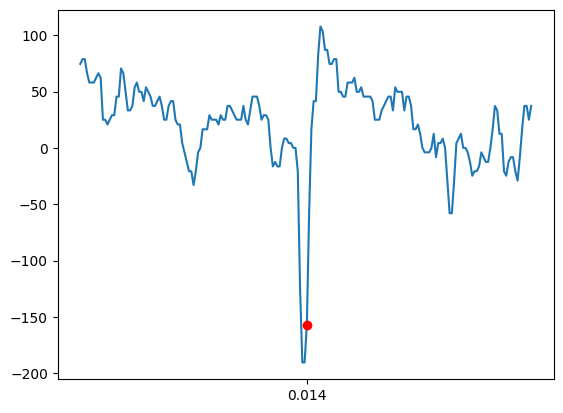

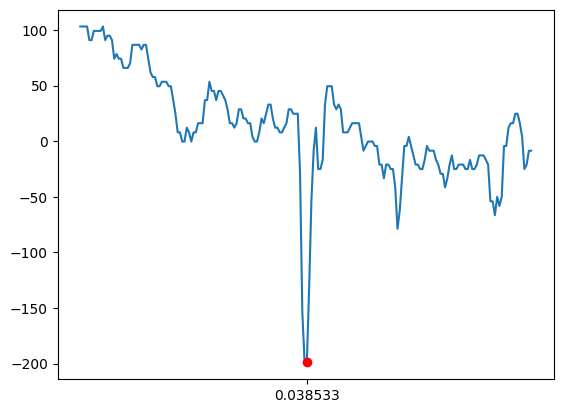

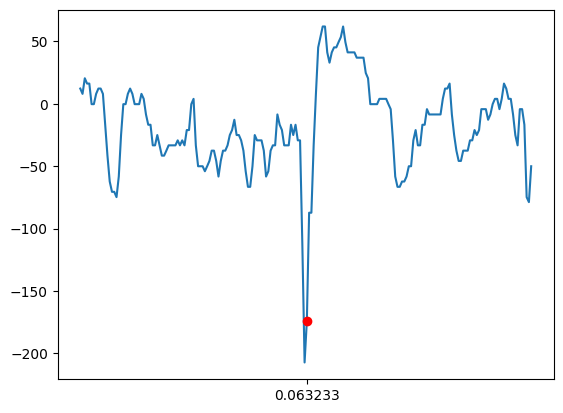

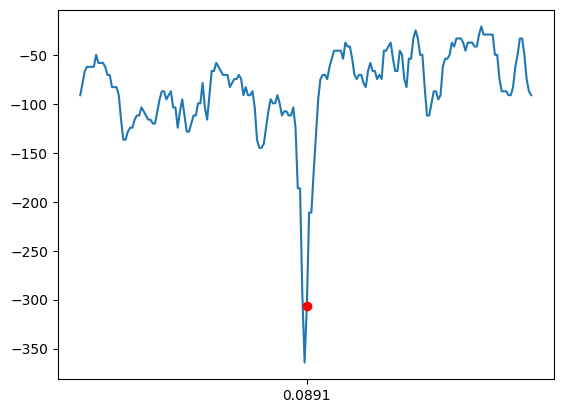

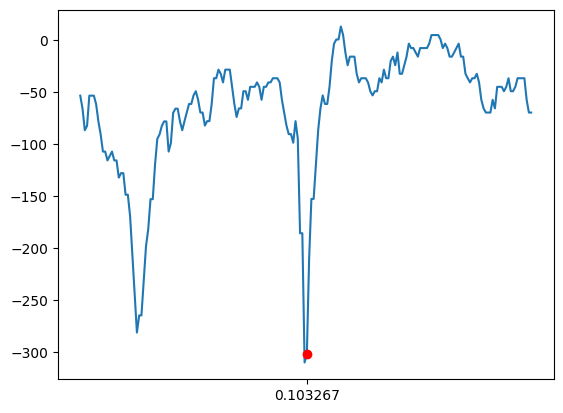

In [19]:
for spkNum in range(5):
    plt.plot(raw_timestamps[spikes_indexed_in_raw[spkNum] - 100 : spikes_indexed_in_raw[spkNum] + 100], 
             raw_data_single_chan[spikes_indexed_in_raw[spkNum] - 100 : spikes_indexed_in_raw[spkNum] + 100])
    plt.plot(raw_timestamps[spikes_indexed_in_raw[spkNum]], raw_data_single_chan[spikes_indexed_in_raw[spkNum]], 'or')
    plt.gca().set_xticks([raw_timestamps[spikes_indexed_in_raw[spkNum]]])
    plt.show()

### Look at an individual reaching segment and link it to the correct kinematics

In [18]:
segment_df.iloc[:10, 0]


id
0     86.905005
1    143.781009
2    162.632343
3    188.889345
4    272.536016
5    299.321684
6    337.585353
7    384.745356
8    387.165690
9    494.087029
Name: start_time, dtype: float64

In [29]:
nwb_acq.processing['video_event_timestamps_moths'].data_interfaces['moths_s_1_e_001_timestamps'].timestamps[:]

array([388.56635045, 388.57135045, 388.57635045, ..., 614.74136042,
       614.74636042, 614.75136042])

In [4]:
segment_idx = 39

# get info in dataframe for specific segment_idx
segment_df = nwb_prc.intervals['reaching_segments_moths'].to_dataframe()
segment_info = segment_df.iloc[segment_idx]

# get event data using container and ndx_pose names from segment_info table following form below:
# nwb.processing['goal_directed_kinematics'].data_interfaces['moths_s_1_e_004_position']
event_data = nwb_prc.processing[segment_info.kinematics_module].data_interfaces[segment_info.video_event] 
hand_kinematics = event_data.pose_estimation_series['hand'].data[:] 
timestamps      = event_data.pose_estimation_series['hand'].timestamps[:]
reproj_error    = event_data.pose_estimation_series['hand'].confidence[:]

# plot full_event 
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(timestamps, hand_kinematics)
axs[0].vlines(x=[segment_info.start_time, segment_info.stop_time], ymin=-3,ymax=14, colors='black', linestyle='dashdot')
axs[1].plot(timestamps, reproj_error, '.b')
axs[0].set_ylabel('Position (cm) for x (blue), y (orange), z (green)')
axs[0].set_title('Entire video event hand kinematics')
axs[1].set_ylabel('Reprojection Error b/w Cameras (pixels)')
axs[1].set_xlabel('Time (sec)')
plt.show()

# extract kinematics of this single reaching segment and plot
reach_hand_kinematics = hand_kinematics[segment_info.start_idx:segment_info.stop_idx]
reach_reproj_error    = reproj_error   [segment_info.start_idx:segment_info.stop_idx]
reach_timestamps      = timestamps     [segment_info.start_idx:segment_info.stop_idx]
peak_idxs = segment_info.peak_extension_idxs.split(',')
peak_idxs = [int(idx) for idx in peak_idxs]
peak_timestamps = timestamps[peak_idxs]
peak_ypos = hand_kinematics[peak_idxs, 1]

# plot single reaching segment 
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(reach_timestamps, reach_hand_kinematics)
axs[0].plot(peak_timestamps, peak_ypos, 'or')
axs[1].plot(reach_timestamps, reach_reproj_error, '.b')
axs[0].set_ylabel('Position (cm) for x (blue), y (orange), z (green)')
axs[0].set_title('Reaching segment hand kinematics')
axs[1].set_ylabel('Reprojection Error b/w Cameras (pixels)')
axs[1].set_xlabel('Time (sec)')
plt.show()

KeyError: 'reaching_segments_moths'

In [41]:
# get table of sorted unit info
units_df = nwb_prc.units.to_dataframe()
elec_positions = units_df.loc[:, ['x', 'y', 'z', 'electrode_label']]
elec_positions

,x,y,z,electrode_label
id,,,,
1,2000.0,2400.0,-1000.0,elec33
3,2000.0,2400.0,-1000.0,elec33
4,2000.0,2400.0,-1000.0,elec33
7,3200.0,1600.0,-1000.0,elec50
9,1600.0,2400.0,-1000.0,elec34
...,...,...,...,...
310,3200.0,1600.0,-1000.0,elec50
332,0.0,2400.0,-1000.0,elec38
335,0.0,2400.0,-1000.0,elec38


### Load and isolate analog channels using electrodes table

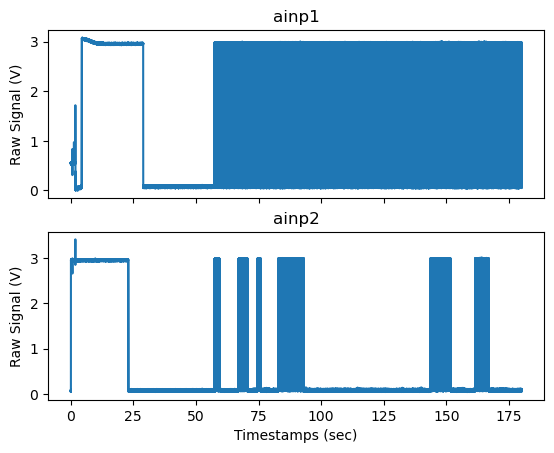

In [42]:
raw = nwb_acq.acquisition['ElectricalSeriesRaw']

start = raw.starting_time
step = 1/raw.rate
stop = start + step*raw.data.shape[0]
raw_timestamps = np.arange(start, stop, step)

elec_df = raw.electrodes.to_dataframe()
analog_idx = [idx for idx, name in elec_df['electrode_label'].iteritems() if 'ainp' in name]
electrode_labels = elec_df.loc[analog_idx, 'electrode_label']

# plot the first 3 minutes of data for the channels
time_to_plot = 3*60
num_samples = int(raw.rate * time_to_plot)
num_channels = np.min([2, len(analog_idx)])
fig, axs = plt.subplots(num_channels, 1, sharex=True) 
for cIdx in range(num_channels):
    analog_signals = raw.data[:num_samples, analog_idx[cIdx]] * elec_df['gain_to_uV'][analog_idx[cIdx]] * raw.conversion
    axs[cIdx].plot(raw_timestamps[:num_samples], analog_signals)
    axs[cIdx].set_title(electrode_labels.iloc[cIdx])
    axs[cIdx].set_ylabel('Raw Signal (V)')

axs[cIdx].set_xlabel('Timestamps (sec)')
    
plt.show()

### Now for a few neural channels

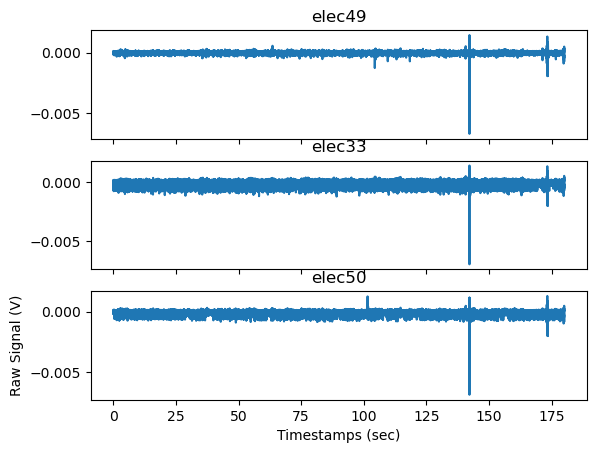

In [43]:
raw = nwb_acq.acquisition['ElectricalSeriesRaw']
elec_df = raw.electrodes.to_dataframe()
analog_idx = [idx for idx, name in elec_df['electrode_label'].iteritems() if 'elec' in name]
electrode_labels = elec_df.loc[analog_idx, 'electrode_label']

# plot the first 3 minutes of data for the channels
time_to_plot = 3*60
num_samples = int(raw.rate * time_to_plot)
num_channels = np.min([3, len(analog_idx)])
fig, axs = plt.subplots(num_channels, 1, sharex=True) 
for cIdx in range(num_channels):
    analog_signals = raw.data[:num_samples, analog_idx[cIdx]] * elec_df['gain_to_uV'][analog_idx[cIdx]] * raw.conversion
    axs[cIdx].plot(raw_timestamps[:num_samples], analog_signals)
    axs[cIdx].set_title(electrode_labels.iloc[cIdx])

axs[cIdx].set_ylabel('Raw Signal (V)')
axs[cIdx].set_xlabel('Timestamps (sec)')
    
plt.show()

### When you finish working with the data, close the files

In [ ]:
io_acq.close()

In [6]:
io_prc.close()